In [2]:
import numpy as np
import pandas as pd

import pymysql
import dotenv
import os
import pickle
import seaborn as sns
import matplotlib

from datetime import timedelta

import matplotlib.pyplot as plt

# Normalization/Standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 경고 무시 코드 추가
import warnings
warnings.filterwarnings('ignore')

def pltconfig_default() :
  sns.reset_defaults()
  %matplotlib inline

pltconfig_default()

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list


In [3]:
# with open('StandardScalar_final_data', 'rb') as file :
#   St_NotEncode_data = pickle.load(file)

St_NotEncode_data = pd.read_pickle("StandardScalar_final_data")
  
# with open('encoded_StandardScalar_final_data', 'rb') as file :
#   St_Encode_data = pickle.load(file)

St_Encode_data = pd.read_pickle("encoded_StandardScalar_final_data")

# with open('MinMaxScaler_final_data', 'rb') as file :
#   MM_NotEncode_data = pickle.load(file)

MM_NotEncode_data = pd.read_pickle("MinMaxScaler_final_data")

# with open('encoded_MinMaxScalar_final_data', 'rb') as file :
#   MM_Encode_data = pickle.load(file)

MM_Encode_data = pd.read_pickle("encoded_MinMaxScalar_final_data")

# with open('Basic_StandardScalar_final_data', 'rb') as file :
#   St_Base_data = pickle.load(file)

St_Base_data = pd.read_pickle("Basic_StandardScalar_final_data")

# with open('Basic_MinMaxScalar_final_data', 'rb') as file :
#   MM_Base_data = pickle.load(file)

MM_Base_data = pd.read_pickle("Basic_MinMaxScalar_final_data")

print(St_NotEncode_data.shape, St_Encode_data.shape, MM_NotEncode_data.shape, MM_Encode_data.shape, St_Base_data.shape, MM_Base_data.shape)

(17422, 9) (17518, 45) (17422, 9) (17518, 45) (52578, 9) (52578, 9)


In [4]:
# Feature와 Label 분리하기
def Feature_Label(datafile) :
    X = datafile.iloc[:,:-1]
    y = datafile.iloc[:,-1]

    return X, y

print("StandardScaler Not Encode Data")
SNE_X, SNE_y = Feature_Label(St_NotEncode_data)
print(SNE_X.shape, SNE_y.shape)
SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = train_test_split(SNE_X, SNE_y, test_size=0.2, random_state=10)
print(SNE_X_train.shape, SNE_X_test.shape, SNE_y_train.shape, SNE_y_test.shape)
print("=======================================")

print("StandardScaler Encode Data")
SE_X, SE_y = Feature_Label(St_Encode_data)
print(SE_X.shape, SE_y.shape)
SE_X_train, SE_X_test, SE_y_train, SE_y_test = train_test_split(SE_X, SE_y, test_size=0.2, random_state=10)
print(SE_X_train.shape, SE_X_test.shape, SE_y_train.shape, SE_y_test.shape)
print("=======================================")

print("MinMaxScaler Not Encode Data")
MMNE_X, MMNE_y = Feature_Label(MM_NotEncode_data)
print(MMNE_X.shape, MMNE_y.shape)
MMNE_X_train, MMNE_X_test, MMNE_y_train, MMNE_y_test = train_test_split(MMNE_X, MMNE_y, test_size=0.2, random_state=10)
print(MMNE_X_train.shape, MMNE_X_test.shape, MMNE_y_train.shape, MMNE_y_test.shape)
print("=======================================")

print("MinMaxScaler Encode Data")
MME_X, MME_y = Feature_Label(MM_Encode_data)
print(MME_X.shape, MME_y.shape)
MME_X_train, MME_X_test, MME_y_train, MME_y_test = train_test_split(MME_X, MME_y, test_size=0.2, random_state=10)
print(MME_X_train.shape, MME_X_test.shape, MME_y_train.shape, MME_y_test.shape)
print("=======================================")

print("StandardScaler Not Encode Data")
SB_X, SB_y = Feature_Label(St_Base_data)
print(SB_X.shape, SB_y.shape)
SB_X_train, SB_X_test, SB_y_train, SB_y_test = train_test_split(SB_X, SB_y, test_size=0.2, random_state=10)
print(SB_X_train.shape, SB_X_test.shape, SB_y_train.shape, SB_y_test.shape)
print("=======================================")

print("MinMaxScaler Not Encode Data")
MMB_X, MMB_y = Feature_Label(MM_Base_data)
print(MMB_X.shape, MMB_y.shape)
MMB_X_train, MMB_X_test, MMB_y_train, MMB_y_test = train_test_split(MMB_X, MMB_y, test_size=0.2, random_state=10)
print(MMB_X_train.shape, MMB_X_test.shape, MMB_y_train.shape, MMB_y_test.shape)
print("=======================================")

StandardScaler Not Encode Data
(17422, 8) (17422,)
(13937, 8) (3485, 8) (13937,) (3485,)
StandardScaler Encode Data
(17518, 44) (17518,)
(14014, 44) (3504, 44) (14014,) (3504,)
MinMaxScaler Not Encode Data
(17422, 8) (17422,)
(13937, 8) (3485, 8) (13937,) (3485,)
MinMaxScaler Encode Data
(17518, 44) (17518,)
(14014, 44) (3504, 44) (14014,) (3504,)
StandardScaler Not Encode Data
(52578, 8) (52578,)
(42062, 8) (10516, 8) (42062,) (10516,)
MinMaxScaler Not Encode Data
(52578, 8) (52578,)
(42062, 8) (10516, 8) (42062,) (10516,)


In [5]:
# Linear Regression, SGDRegressor (시계열을 고려하지 않은 경우)
for m in [LinearRegression(), SGDRegressor(max_iter=1000)] :
    m.fit(SNE_X_train, SNE_y_train)

    print(m.coef_, m.intercept_)
    print('train score', m.score(SNE_X_train, SNE_y_train))
    print('test score', m.score(SNE_X_test, SNE_y_test))
    print('=========================================================')


for m in [LinearRegression(), SGDRegressor(max_iter=1000)] :
    m.fit(MMNE_X_train, MMNE_y_train)

    print(m.coef_, m.intercept_)
    print('train score', m.score(MMNE_X_train, MMNE_y_train))
    print('test score', m.score(MMNE_X_test, MMNE_y_test))
    print('=========================================================')


for m in [LinearRegression(), SGDRegressor(max_iter=1000)] :
    m.fit(SB_X_train, SB_y_train)

    print(m.coef_, m.intercept_)
    print('train score', m.score(SB_X_train, SB_y_train))
    print('test score', m.score(SB_X_test, SB_y_test))
    print('=========================================================')

[   45.09304073  -214.30728068   223.02029914 -1866.40364428
  8236.42132297   496.08102667  -201.28223039  1733.94738915] 7513.307602041742
train score 0.7776321961147403
test score 0.7638045949108958
[   60.14171236  -142.89361368   167.03517889 -1939.02889821
  8193.35673999   537.79660149  -101.5224657   1710.23437718] [7503.45537776]
train score 0.7774076533224152
test score 0.7638933255812885
[ 1652.38178697 -1687.08951794   606.76106795 -8200.6339408
 20020.02599603  1242.89858926 -5829.33070179  9144.94993845] 3218.638560989609
train score 0.7776321961147403
test score 0.7638045949108958
[  103.31760309  -921.91705507   591.67169738 -7430.03441801
 20156.6369265   1250.8668093   -446.71276989  8809.37172463] [2537.64014286]
train score 0.7772723533656563
test score 0.7640126496639652
[ 0.16557035  0.03415983 -0.01167191 -0.2723274   1.32830857 10.9063008
  0.03251048  1.25167298] 9.131986023428711
train score 0.9026441883996681
test score 0.9076004904984573
[ 1.20145971e-01  1.

In [6]:
# multivariate_data 파라미터 세팅
timesteps_length = 24*7
New_train_split = 14014 # train set과 test set 비율을 80:20으로 맞췄을 때 경계값
Basic_train_split = 42062 # train set과 test set 비율을 80:20으로 맞췄을 때 경계값
future_target = 24 # 다음 24시간 미래 예측
STEP = 2

In [7]:
# 다변량 시계열 데이터 (Multivariate Time Series Data)
# dataset : 원본 시계열 데이터 (2D Dataframe)
# target : 예측 대상 변수 (1D Dataframe)
# start_index : 학습 데이터의 시작 인덱스 / end_index : 학습 데이터의 끝 인덱스
# history_size : 과거 정보로 사용할 데이터 포인트 수
# target_size : 예측 대상으로 사용할 데이터 포인트 수
# step : 데이터 포인트 간의 간격

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=True):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [8]:
# 데이터프레임은 열 이름과 인덱스를 가지고 있으나 넘파이 배열의 경우 순수한 다차원 배열로 되어 있어 순서에 따라 접근이 가능하므로 to_numpy 적용이 필요하다
# 데이터프레임을 그대로 적용할 경우 KeyError가 발생하지만 넘파이 배열로 변경하게 되면 해당 부분이 문제가 되지 않는다

def  to_timeseries_data(X, y, train_split):
  X_train, y_train = multivariate_data(X.to_numpy(), y, 0, train_split, timesteps_length, future_target, STEP, single_step=True)
  X_test, y_test = multivariate_data(X.to_numpy(), y, train_split, None, timesteps_length, future_target, STEP, single_step=True)
  
  return X_train, X_test, y_train, y_test

print("StandardScaler Not Encode Data")
SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = to_timeseries_data(SNE_X, SNE_y, New_train_split)
print(SNE_X_train.shape, SNE_X_test.shape)
print("=======================================")

print("StandardScaler Encode Data")
SE_X_train, SE_X_test, SE_y_train, SE_y_test = to_timeseries_data(SE_X, SE_y, New_train_split)
print(SE_X_train.shape, SE_X_test.shape)
print("=======================================")

print("MinMaxScaler Not Encode Data")
MMNE_X_train, MMNE_X_test, MMNE_y_train, MMNE_y_test = to_timeseries_data(MMNE_X, MMNE_y, New_train_split)
print(MMNE_X_train.shape, MMNE_X_test.shape)
print("=======================================")

print("MinMaxScaler Encode Data")
MME_X_train, MME_X_test, MME_y_train, MME_y_test = to_timeseries_data(MME_X, MME_y, New_train_split)
print(MME_X_train.shape, MME_X_test.shape)
print("=======================================")

print("StandardScaler Not Encode Basic Data")
SB_X_train, SB_X_test, SB_y_train, SB_y_test = to_timeseries_data(SB_X, SB_y, Basic_train_split)
print(SB_X_train.shape, SB_X_test.shape)
print("=======================================")

print("MinMaxScaler Not Encode Basic Data")
MMB_X_train, MMB_X_test, MMB_y_train, MMB_y_test = to_timeseries_data(MMB_X, MMB_y, Basic_train_split)
print(MMB_X_train.shape, MMB_X_test.shape)
print("=======================================")


# 적용 테스트

# X_train, y_train = multivariate_data(SNE_X.to_numpy(), SNE_y, 0, New_train_split, timesteps_length, future_target, STEP, single_step=True)
# X_test, y_test = multivariate_data(SNE_X.to_numpy(), SNE_y, New_train_split, None, timesteps_length, future_target, STEP, single_step=True)

# print(X_train.shape, X_test.shape)
# print(X_train.shape[0]+X_test.shape[0]) # 기존 17518
# print(y_train.shape, y_test.shape)

StandardScaler Not Encode Data
(13846, 84, 8) (3216, 84, 8)
StandardScaler Encode Data
(13846, 84, 44) (3312, 84, 44)
MinMaxScaler Not Encode Data
(13846, 84, 8) (3216, 84, 8)
MinMaxScaler Encode Data
(13846, 84, 44) (3312, 84, 44)
StandardScaler Not Encode Basic Data
(41894, 84, 8) (10324, 84, 8)
MinMaxScaler Not Encode Basic Data
(41894, 84, 8) (10324, 84, 8)


In [9]:
# Feature와 Label 분리하기
def Feature_Label(datafile) :
    X = datafile.iloc[:,:-1]
    y = datafile.iloc[:,-1]

    return X, y

print("StandardScaler Not Encode Data")
SNE_X, SNE_y = Feature_Label(St_NotEncode_data)
print(SNE_X.shape, SNE_y.shape)
SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = train_test_split(SNE_X, SNE_y, test_size=0.2, random_state=10)
print(SNE_X_train.shape, SNE_X_test.shape, SNE_y_train.shape, SNE_y_test.shape)
print("=======================================")

StandardScaler Not Encode Data
(17422, 8) (17422,)
(13937, 8) (3485, 8) (13937,) (3485,)


<Axes: ylabel='8'>

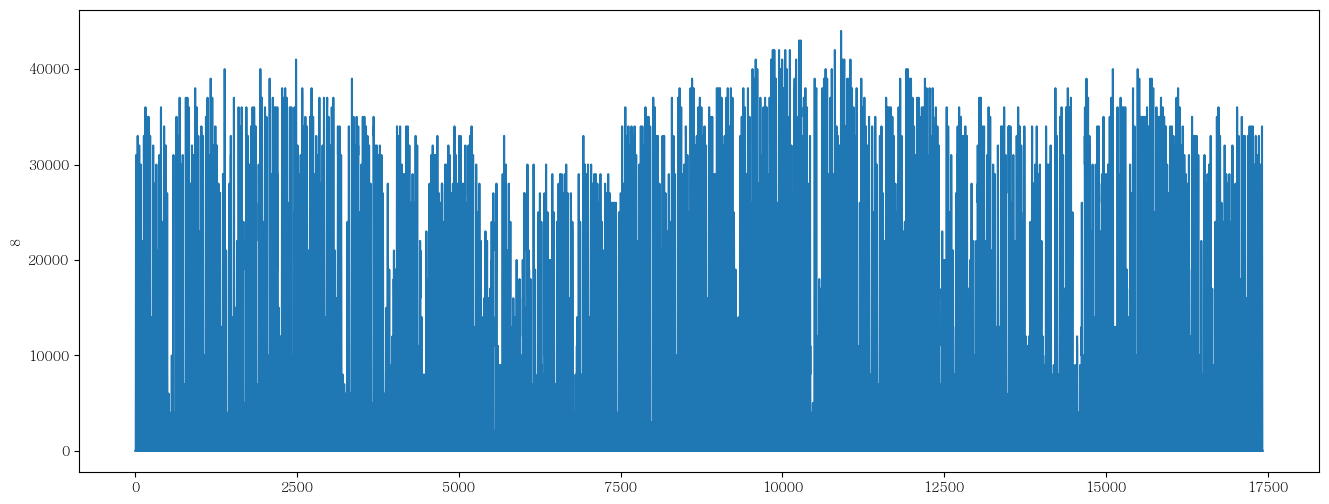

In [14]:
# fig, axe = plt.subplots(figsize=(16, 6), layout='constrained')
plt.figure(figsize=(16, 6))

sns.lineplot(y=SNE_y, x=SNE_X[1].index)